<a href="https://colab.research.google.com/github/zulmarina1687/MCC-VA/blob/main/Lab1_Convolution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import sys
import cv2
import numpy as np
from matplotlib import pyplot as plt
import math

In [ ]:
file_name = "pikachu"
path = "/content/drive/My Drive/Maestria/VA/Laboratorio1/"

(400, 400, 4)


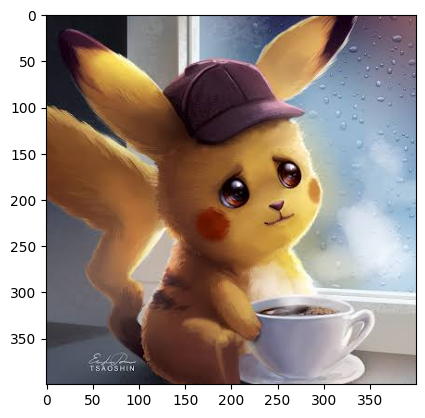

In [ ]:
img = plt.imread(path+file_name+'.jpg')
print(img.shape)
plt.imshow(img)
plt.show()

In [ ]:
import os
import subprocess

In [ ]:
!apt install libopencv-dev

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libopencv-dev is already the newest version (4.5.4+dfsg-9ubuntu4+jammy0).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.


In [ ]:
!pip install nvcc4jupyter

In [ ]:
%load_ext nvcc4jupyter

The nvcc4jupyter extension is already loaded. To reload it, use:
  %reload_ext nvcc4jupyter


In [ ]:
COMPILER_ARGS = subprocess.check_output(["pkg-config", "--cflags", "--libs", "opencv4"]).decode().strip()
print(COMPILER_ARGS)

-I/usr/include/opencv4 -lopencv_stitching -lopencv_alphamat -lopencv_aruco -lopencv_barcode -lopencv_bgsegm -lopencv_bioinspired -lopencv_ccalib -lopencv_dnn_objdetect -lopencv_dnn_superres -lopencv_dpm -lopencv_face -lopencv_freetype -lopencv_fuzzy -lopencv_hdf -lopencv_hfs -lopencv_img_hash -lopencv_intensity_transform -lopencv_line_descriptor -lopencv_mcc -lopencv_quality -lopencv_rapid -lopencv_reg -lopencv_rgbd -lopencv_saliency -lopencv_shape -lopencv_stereo -lopencv_structured_light -lopencv_phase_unwrapping -lopencv_superres -lopencv_optflow -lopencv_surface_matching -lopencv_tracking -lopencv_highgui -lopencv_datasets -lopencv_text -lopencv_plot -lopencv_ml -lopencv_videostab -lopencv_videoio -lopencv_viz -lopencv_wechat_qrcode -lopencv_ximgproc -lopencv_video -lopencv_xobjdetect -lopencv_objdetect -lopencv_calib3d -lopencv_imgcodecs -lopencv_features2d -lopencv_dnn -lopencv_flann -lopencv_xphoto -lopencv_photo -lopencv_imgproc -lopencv_core


In [ ]:
%%cuda --compiler-args "$COMPILER_ARGS"

#include <iostream>
#include <string>

#include <opencv2/core/core.hpp>
#include <opencv2/highgui/highgui.hpp>
#include <opencv2/imgproc/imgproc.hpp>

using namespace std;
using namespace cv;

string file_name = "pikachu";
string path = "/content/drive/My Drive/Maestria/VA/Laboratorio1/";

#define CHECK(call){const cudaError_t error = call;if (error != cudaSuccess){printf("Error: %s:%d, ", __FILE__, __LINE__);printf("code:%d, reason: %s\n", error, cudaGetErrorString(error));exit(1);}}

// template to easily create new cuda arrays
template <class T>
T* cuda_array(int n){
  T* arr;
  size_t tam = n * sizeof(T);
  CHECK(cudaMalloc(&arr, tam));
  return arr;
}

// template to copy array from host to device
template <class T>
void cuda_H2D(T* h_arr, T* d_arr, int n){
  size_t tam = n * sizeof(T);
  CHECK(cudaMemcpy(d_arr, h_arr, tam, cudaMemcpyHostToDevice));
}

// template to copy array from device to host
template <class T>
void cuda_D2H(T* d_arr, T* h_arr, int n){
  size_t tam = n * sizeof(T);
  CHECK(cudaMemcpy(h_arr, d_arr, tam, cudaMemcpyDeviceToHost));
}


__global__ void conv(unsigned char* d_data, float* d_kernel, int k, int p, int pos_k, int pos_p, int h, int w){
  int i = blockIdx.x * blockDim.x + threadIdx.x;
  int j = blockIdx.y * blockDim.y + threadIdx.y;
  if(i < w && j < h){
    float sum_c1 = 0;
    float sum_c2 = 0;
    float sum_c3 = 0;
    for (size_t r = 0; r < k; r++) {
      for (size_t c = 0; c < p; c++) {
        sum_c1 += d_data[(j - pos_k + r) * (3 * w) + ((i - pos_p + c) * 3)] * d_kernel[r * p + c];
        sum_c2 += d_data[(j - pos_k + r) * (3 * w) + ((i - pos_p + c) * 3) + 1] * d_kernel[r * p + c];
        sum_c3 += d_data[(j - pos_k + r) * (3 * w) + ((i - pos_p + c) * 3) + 2] * d_kernel[r * p + c];
      }
    }
    d_data[j * 3 * w + i * 3] = sum_c1;
    d_data[j * 3 * w + i * 3 + 1] = sum_c2;
    d_data[j * 3 * w + i * 3 + 2] = sum_c3;
  }
}

Mat aplicar_filtro(Mat& img_i, float* kernel, int k , int p, int i, int j){
  Mat img = img_i.clone();
  int h, w;
  h = img.size().height;
  w = img.size().width;


  float block_size = 16;
  dim3 block =  dim3(block_size, block_size, 1);
  dim3 grid =  dim3(ceil(w / block_size), ceil(h / block_size), 1);

  unsigned char* data = (unsigned char*)img.data;
  unsigned char* d_data = cuda_array<unsigned char>(h * w * 3);
  float* d_kernel = cuda_array<float>(k * p);


  cuda_H2D(data, d_data, h * w * 3);
  cuda_H2D(kernel, d_kernel, k * p);
  conv<<<grid, block>>>(d_data, d_kernel, k, p, i, j, h, w);
  cudaDeviceSynchronize();
  cuda_D2H(d_data, data, h * w * 3);
  cudaFree(d_kernel);
  return img;

}


int main(void)
{
  std::string input_file;
  std::string output_file1;
  std::string output_file2;
  std::string output_file3;
  std::string output_file4;

  input_file   = path + file_name + ".jpg";
  output_file1 = path + file_name + "_Sobelx_gpu.jpg";
  output_file2 = path + file_name + "_Sobely_gpu.jpg";
  output_file3 = path + file_name + "_Perfilado_gpu.jpg";
  output_file4 = path + file_name + "_FiltroGaussiano_gpu.jpg";

  cv::Mat img = imread(input_file.c_str());
  //resize(img, img,cv::Size(), 0.1, 0.1);


  float kernel_Sobel_X[9] =
  {-1, 0, 1,
  -2, 0, 2,
  -1, 0, 1};

  float kernel_Sobel_Y[9] =
  {-1, -2, -1,
   0, 0, 0,
   1, 2, 1};

  float kernel_perfilado[9] =
  {-1, -1, -1,
  -1, 9, -1,
  -1, -1, -1};

  float kernel_filtro_gaussiano_l[7] =
  {1.0 / 64.0,
  6.0 / 64.0,
  15.0 / 64.0,
  20.0 / 64.0,
  15.0 / 64.0,
  6.0 / 64.0,
  1.0 / 64.0};


  cv::Mat sobel_x, sobel_y, perfilado, borde_suavizado, filtro_gaussiano;
  sobel_x = aplicar_filtro(img, &kernel_Sobel_X[0], 3, 3, 1, 1);
  sobel_y = aplicar_filtro(img, &kernel_Sobel_Y[0], 3, 3, 1, 1);
  perfilado = aplicar_filtro(img, &kernel_perfilado[0], 3, 3, 1, 1);
  filtro_gaussiano = aplicar_filtro(img, &kernel_filtro_gaussiano_l[0], 1, 7, 3, 1);
  filtro_gaussiano = aplicar_filtro(filtro_gaussiano, &kernel_filtro_gaussiano_l[0], 7, 1, 0, 3);

  cv::imwrite(output_file1.c_str(), sobel_x);
  cv::imwrite(output_file2.c_str(), sobel_y);
  cv::imwrite(output_file3.c_str(), perfilado);
  cv::imwrite(output_file4.c_str(), filtro_gaussiano);
   waitKey(0);


  return 0;
}

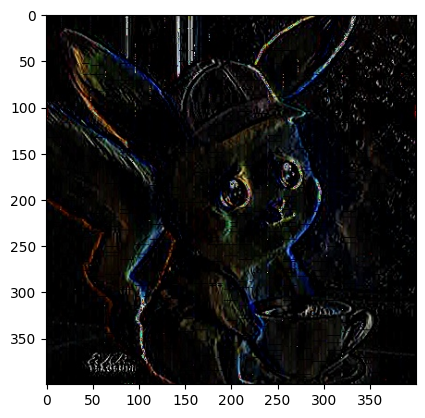

In [ ]:
img = plt.imread(path+file_name+'_Sobelx_gpu.jpg')
plt.imshow(img)
plt.show()

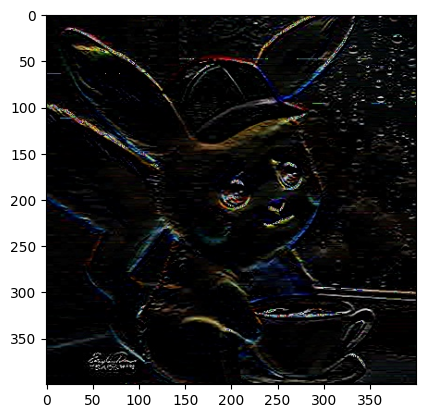

In [ ]:
img = plt.imread(path+file_name+'_Sobely_gpu.jpg')
plt.imshow(img)
plt.show()

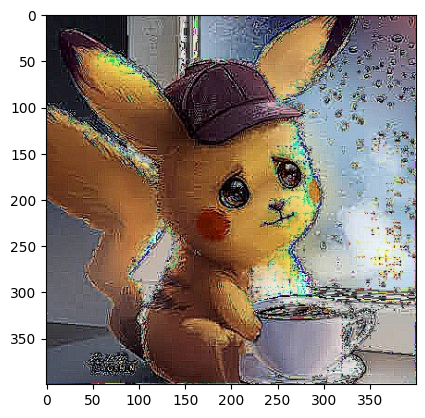

In [ ]:
img = plt.imread(path+file_name+'_Perfilado_gpu.jpg')
plt.imshow(img)
plt.show()

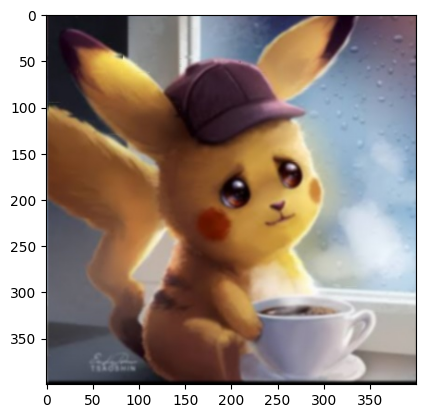

In [ ]:
img = plt.imread(path+file_name+'_FiltroGaussiano_gpu.jpg')
plt.imshow(img)
plt.show()